In [1]:
import pandas as pd
from datetime import date
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.utils import resample
import numpy as np

sns.set()
plt.rcParams['figure.figsize'] = [15, 10]

## Load data

In [2]:
# Read data
spends = pd.read_csv("/spend.csv")
counts = pd.read_csv("/counts.csv")

# Review data
spends.head()
counts.head()

,account,date,count
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,56
1,a04e063493c55bc6cecd9056712e9e47,2017-08-16,180
2,ff6cc8cadcb7457f9ddb2dd238a13733,2017-08-16,432
3,324a05f1f917b8a0af83a54e55a1ef63,2017-08-16,50
4,b9abff45dc08172b556cb10b7c3c2252,2017-08-16,135


## Basic Explore

In [3]:
# The volumn of spends is different with the volumn of counts
# Count the number of rows in each table
print(spends.shape)
print(counts.shape)

(1934135, 3)
(1934028, 3)


In [4]:
# Count the number of distinct account_id in each table
spends_cnt = spends.groupby("account").count().date 
counts_cnt = counts.groupby("account").count().date 
print(spends_cnt.shape)
print(counts_cnt.shape)

(10001,)
(9999,)


In [5]:
# Left join two table to see the number of rows of each account_id
df1 = pd.DataFrame(counts_cnt)
df2 = pd.DataFrame(spends_cnt)
Left_table = df1.merge(df2,how="left", left_index=True, right_index=True, suffixes=('_cnt', '_spd'))

In [6]:
# Except for 2 accounts ids only appeared in Spends Table, I found there are two ids have different number of raws
Left_table[Left_table.date_cnt != Left_table.date_spd]

,date_cnt,date_spd
account,,
ab1317dd5bf062ab4df87248d4ed5bfd,121,120
ca8857e721c02becf6d436ef3623b65a,383,382


In [3]:
# I found the incorrect value "102841600" which is possiblly "1502841600"
# Checked this value according to its account_id and approved my guess
# So I directly correct it with "1502841600"
spends.head(10)
spends.iloc[1,1] = 1502841600

# Then I change the date form into "xxx-xx-xx"
# The dates in counts table are generally one day later than the dates of spends table
# So I added one day to the dates in spends table in order to make two table consistent
spends["date"] = spends.date.apply(lambda x : str(date.fromtimestamp(x + 100000)))
spends.head()

,account,date,amount
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,15.144020
1,a04e063493c55bc6cecd9056712e9e47,2017-08-16,730.070453
2,ff6cc8cadcb7457f9ddb2dd238a13733,2017-08-16,3651.412248
3,324a05f1f917b8a0af83a54e55a1ef63,2017-08-16,113.219243
4,b9abff45dc08172b556cb10b7c3c2252,2017-08-16,697.224210


In [8]:
#Compare the counts information and amount information by account_id
counts[counts.account == "5e0a5eb5575517efdddb2799c90e2e9b"].sort_values("date").head()
spends[spends.account == "5e0a5eb5575517efdddb2799c90e2e9b"].sort_values("date").head()

,account,date,amount
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,15.144020
1732,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-18,4124.529983
2234,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-19,62.037521
6358,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-20,449.466683
876412,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-21,2.270190


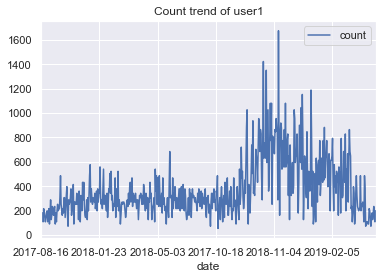

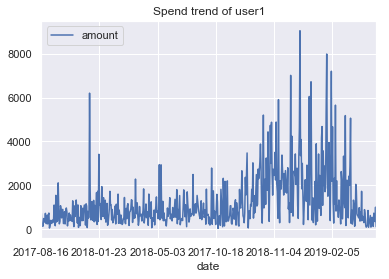

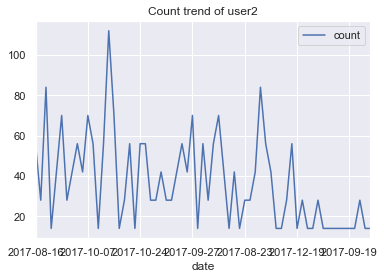

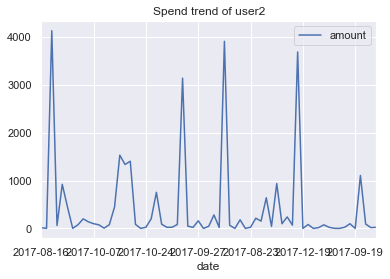

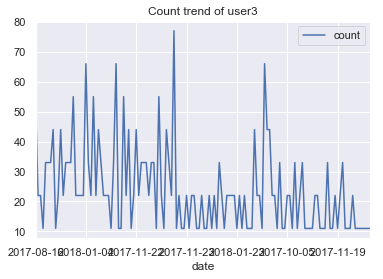

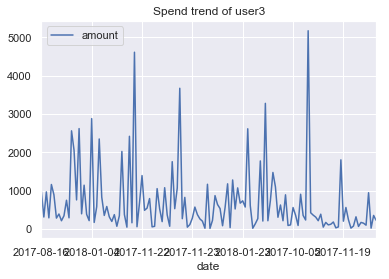

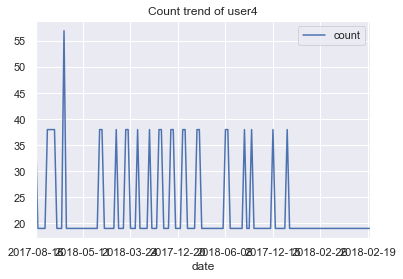

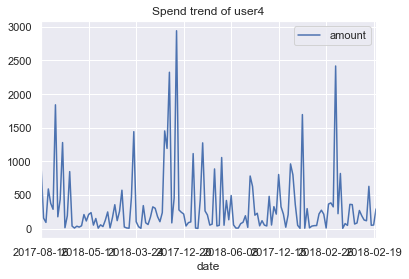

In [9]:
# Plot the line chart of counts and spends for a specific user
user_list = ["a04e063493c55bc6cecd9056712e9e47",
             "5e0a5eb5575517efdddb2799c90e2e9b",
             "cdc9c7ff5c7da1ea1b35fae6ae248f91",
             "ba4c9867567e1ac41f175f0c3258879d" ]

for i,v in enumerate(user_list):
    user1_count = counts[counts.account == v]
    user1_count = user1_count.set_index("date")
    user1_count.plot.line()
    plt.title("Count trend of user" + str(i+1))

    user1_spend = spends[spends.account == v]
    user1_spend = user1_spend.set_index("date")
    user1_spend.plot.line()
    plt.title("Spend trend of user" + str(i+1))
    

In [4]:
# Inner join two tables
merged_table = pd.merge(spends, counts,on=["account","date"], how="inner")

## Valuable Metrics

### Average counts and spends

Text(0.5, 1.0, 'The monthly average counts and spends changing over time')

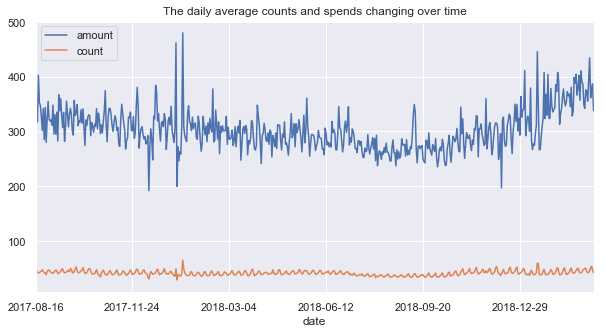

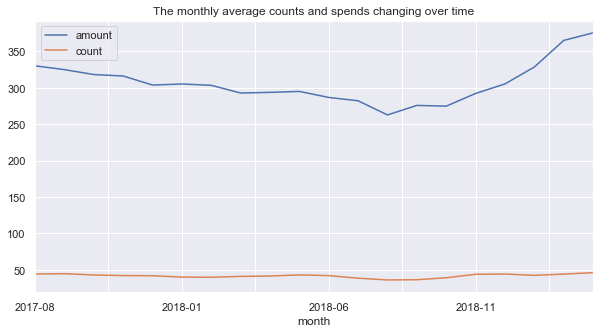

In [5]:
# Plot the line chart of average counts and spends

# Daily
plt.rcParams['figure.figsize'] = [10, 5]
average_daily = merged_table.groupby("date").mean()
average_daily.plot.line()
plt.title("The daily average counts and spends changing over time")

# Monthly
merged_table2 = merged_table.copy()
merged_table2["month"] = merged_table2.date.apply(lambda x: x[:7])
average_monthly = merged_table2.groupby("month").mean()
average_monthly.plot.line()
plt.title("The monthly average counts and spends changing over time")

### Daily/Monthly Active User

There are no dupilicates: True


Text(0.5, 1.0, 'The number of MAU(Monthly Active User)')

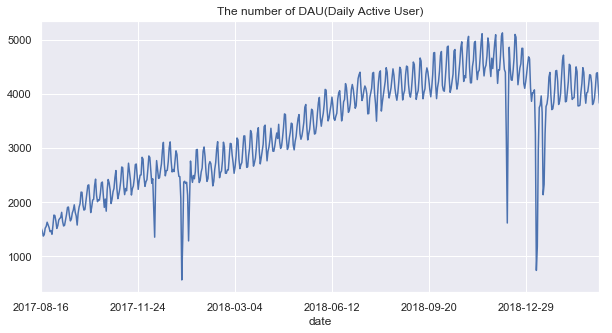

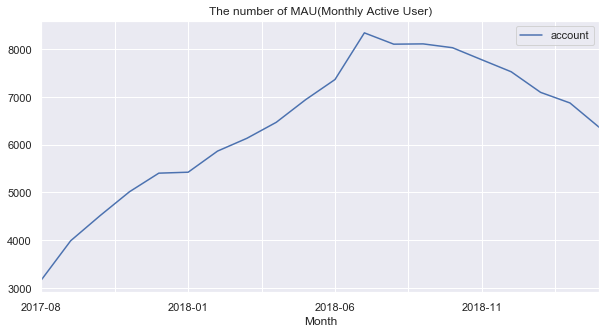

In [6]:
# Plot the line chart of number of DAU and MAU

# Daily
merged_table3 = merged_table.copy()
print("There are no dupilicates: "+str(merged_table.drop_duplicates().count()[1] == merged_table.count()[1]))
Active_daily = merged_table3.groupby("date").count().account
Active_daily.plot.line()
plt.title("The number of DAU(Daily Active User)")

# Monthly
merged_table4 = merged_table.copy()
merged_table4["Month"] = merged_table4.date.apply(lambda x: x[:7])
Active_monthly = merged_table4[["Month","account"]].drop_duplicates()
Active_monthly = Active_monthly.groupby("Month").count()
Active_monthly.plot.line()
plt.title("The number of MAU(Monthly Active User)")

## Label churned acount

### Explore the time period

In [7]:
# Because the dataset is too big, it's hard to join tables with condition on date
# Then, I used the YEAR-MONTH information to calculate the time period
# It costs less computation to join tables
interval = merged_table4[["Month","account"]].drop_duplicates()
engine   = create_engine('sqlite://', echo=False)
interval.to_sql('interval', con=engine)

sql_statement   = '''select current.account, current.month as current, last.month as last_
                     from interval as current
                     left join interval as last on current.account = last.account
                     where current.month > last.month'''
merged_interval = pd.read_sql_query(sql_statement, engine)

merged_interval["current"] = merged_interval.current.astype("datetime64[ns]")
merged_interval["last_"] = merged_interval.last_.astype("datetime64[ns]")

In [8]:
# Calculate the time-periods of each transaction.
# Select 
merged_interval["period"] = merged_interval["current"] - merged_interval["last_"]
time_period  = merged_interval.groupby(["account","current"]).min()
time_period  = pd.DataFrame(time_period, columns=["period"]).reset_index()
period_distr = time_period.groupby("period").count()
period_distr = period_distr.reset_index()
period_distr["period"] = period_distr.period.apply(lambda x: x.days)

print ("Percentage of transactions that were made in 59 days:")
print (period_distr[period_distr.period < 60].sum().current/period_distr.sum().current)

Percentage of transactions that were made in 59 days:
0.9860188833669431


Text(0.5, 1.0, 'Time period distribution')

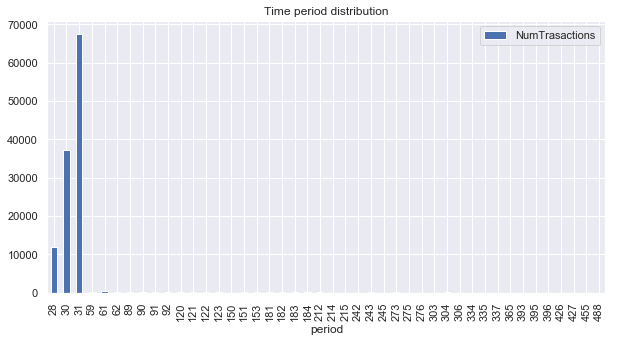

In [9]:
# Plot the bar graph of time period graph
period_distr["NumTrasactions"] = period_distr.account
period_distr.plot.bar(x="period",y="NumTrasactions")
plt.title("Time period distribution")

Text(0.5, 1.0, 'Cumulative Line of Time Period Ratio')

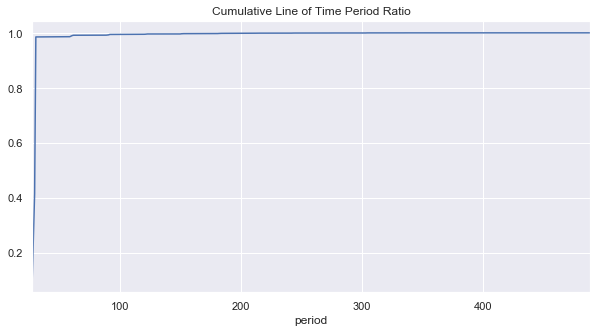

In [10]:
# Plot the cumulative rate of transactions that are made in a time period
period_distr    = period_distr.set_index("period")
period_accum    = pd.DataFrame(period_distr["account"].cumsum())
period_quantile = period_accum["account"]/period_accum["account"].max()
period_quantile.plot.line()
plt.title("Cumulative Line of Time Period Ratio")

When a user have stoped making transcation for more than 59 days, he could be assumed as churned user.

### Label data

In [82]:
# Lable the data with the rule we concluded previously
# That is if a user didn't make a transaction in 59 days, then he/she is assumed at risk of churning
merged_table5          = merged_table.copy()
merged_table5["date"]  = merged_table5.date.astype("datetime64[ns]")
lifetime               = merged_table5[["account","date"]].groupby("account").max()
lifetime["start_date"]   = merged_table5[["account","date"]].groupby("account").min().date
lifetime.columns    = ["max_date", "start_date"]
end_time            = lifetime.max_date.max()
lifetime['churned'] = lifetime.max_date.apply(lambda x: 1 if (end_time - x).days > 59 else 0)

In [27]:
# The dataset is a bit unbalanced
lifetime.churned.value_counts()

0    7132
1    2867
Name: churned, dtype: int64

In [28]:
# Ckeck the dataset
merged_table.head()
lifetime.head()

# Merge the datasets to label data
sample = merged_table.merge(lifetime, left_on="account", right_on="account", how="left")
print("The joined table shape is: ")
print(sample.shape)

# Select dataset for training and evaluating
sample["date"]     = sample.date.astype("datetime64[ns]")
sample["set_type"] = sample.date.apply(lambda x: "train" if (end_time - x).days > 59 and (end_time - x).days <= 118 else "label")

train_set = sample[sample.set_type == "train"]
label_set = sample[sample.set_type == "label"]

The joined table shape is: 
(1934026, 7)


In [29]:
# Check the split of dataset
print(train_set.date.min())
print(train_set.date.max())
print(label_set.date.min())
print(label_set.date.max())

# Check the data balance        (# label_set.churned.value_counts())
train_set.churned.value_counts()

2018-11-17 00:00:00
2019-01-14 00:00:00
2017-08-16 00:00:00
2019-03-15 00:00:00


0    237255
1     12887
Name: churned, dtype: int64

## Create features

In [30]:
# average spends, max spends, min spends, spends variance
# average counts, max counts, min counts, counts variance
Feature1 = train_set.groupby("account").mean()[["amount","count"]]
Feature1 = Feature1.merge(train_set.groupby("account").max()[["amount","count"]],
                          left_on="account",right_on="account", suffixes=('_ave', '_max'))
Feature1 = Feature1.reset_index()

Feature2 = train_set.groupby("account").min()[["amount","count"]]
Feature2 = Feature2.merge(train_set.groupby("account").var()[["amount","count"]],
                          left_on="account",right_on="account", suffixes=('_min', '_var'))
Feature2 = Feature2.reset_index()

# Fill NaN in Feature2
Feature2["amount_var"] = Feature2["amount_var"].fillna(0)
Feature2["count_var"] = Feature2["count_var"].fillna(0)

# Total spends and total counts
Feature3 = train_set.groupby("account").sum()[["amount","count"]]
Feature3.columns = ["amount_sum", "count_sum"]
Feature3 = Feature3.reset_index()

In [83]:
# Start_time, time spent, response
max_date = train_set[["account","date"]].groupby("account").max().reset_index()
lifetime = lifetime.drop("max_date", axis=1).reset_index()
lifetime = lifetime.merge(max_date, how ="left", on="account")
lifetime.columns = ["account", "start_date", "churned", "max_date"]
lifetime["time_spent"] = (lifetime.max_date - lifetime.start_date)

Feature4 = lifetime[["account","start_date", "time_spent", "churned"]].copy()
Feature4["time_spent"] = Feature4.time_spent.apply(lambda x: x.days + 1)
Feature4["start_date"] = Feature4.start_date.apply(lambda x: str(x)[:7])

In [85]:
# Join all features into on table
Features = Feature1.merge(Feature2, on="account", how="inner").merge(Feature3,on="account", how="inner").merge(Feature4,on="account", how="inner")
Features["count_per_day"] = Features["count_sum"]/Features["time_spent"]
Features["spend_per_day"] = Features["amount_sum"]/Features["time_spent"]

In [86]:
# Check the final dataset and the original dataset
print(train_set.account.drop_duplicates().count())
print(merged_table.account.drop_duplicates().count())
print(lifetime.reset_index().account.drop_duplicates().count())
Features.describe()

7764
9999
9999


,amount_ave,count_ave,amount_max,count_max,amount_min,count_min,amount_var,count_var,amount_sum,count_sum,time_spent,churned,count_per_day,spend_per_day
count,7764.000000,7764.000000,7764.000000,7764.000000,7.764000e+03,7764.000000,7.764000e+03,7764.000000,7.764000e+03,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000
mean,339.772419,35.380619,2012.907788,85.756054,3.922806e+01,15.940623,2.258235e+06,897.093435,9.837736e+03,1411.076893,351.056543,0.099176,5.460251,57.487974
std,2577.878014,59.326725,4994.009515,124.274025,1.633486e+03,15.633942,8.149471e+07,10633.117818,2.611693e+04,3468.427842,139.394337,0.298917,12.505324,1172.735701
min,0.000340,10.000000,0.000340,10.000000,1.032155e-12,10.000000,0.000000e+00,0.000000,3.395212e-04,10.000000,1.000000,0.000000,0.021645,0.000001
25%,72.405857,19.234687,401.165775,40.000000,5.259362e-01,13.000000,9.215164e+03,71.529485,1.831552e+03,416.000000,224.000000,0.000000,1.140067,5.280542
50%,158.116059,25.445221,941.548767,60.000000,1.827551e+00,15.000000,4.744518e+04,176.337456,4.412826e+03,780.000000,377.000000,0.000000,2.497475,13.898356
75%,324.529944,35.380637,2147.895309,96.000000,5.869375e+00,18.000000,2.282407e+05,426.486364,1.001822e+04,1460.000000,492.000000,0.000000,5.326801,34.756934
max,188953.911458,3209.203390,244192.048700,5313.000000,1.337158e+05,1199.000000,6.102504e+09,617240.164816,1.552500e+06,189343.000000,517.000000,1.000000,366.234043,75581.564583


## Exploritary Data Aanalysis

In [87]:
# Check the data imbalance
churned = Features[Features.churned == 1]
unchurned = Features[Features.churned == 0]
print(churned.shape)
print(unchurned.shape)

(770, 16)
(6994, 16)


In [88]:
# Upsample to make it balanced
churned_upsampled = resample(churned, 
                             replace=True,     # sample with replacement
                             n_samples=6994,    # to match majority class
                             random_state=123)
df_upsampled = pd.concat([churned_upsampled, unchurned])

In [89]:
# Downsample to make it balanced
unchurned_downsampled = resample(unchurned, 
                                 replace=False,    # sample without replacement
                                 n_samples=770,     # to match minority class
                                 random_state=123)
df_downsampled = pd.concat([unchurned_downsampled, churned])

In [90]:
# Check the descriptive statistics of each feature
# df_upsampled.columns
df_upsampled.groupby("churned").describe().amount_var

,count,mean,std,min,25%,50%,75%,max
churned,,,,,,,,
0,6994.0,1.671988e+06,7.379456e+07,0.0,9790.573228,48681.344840,230248.005416,6.102504e+09
1,6994.0,7.256724e+06,1.351754e+08,0.0,3939.442543,37960.717716,196977.168216,3.496819e+09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a514d3ef0>,
      dtype=object)

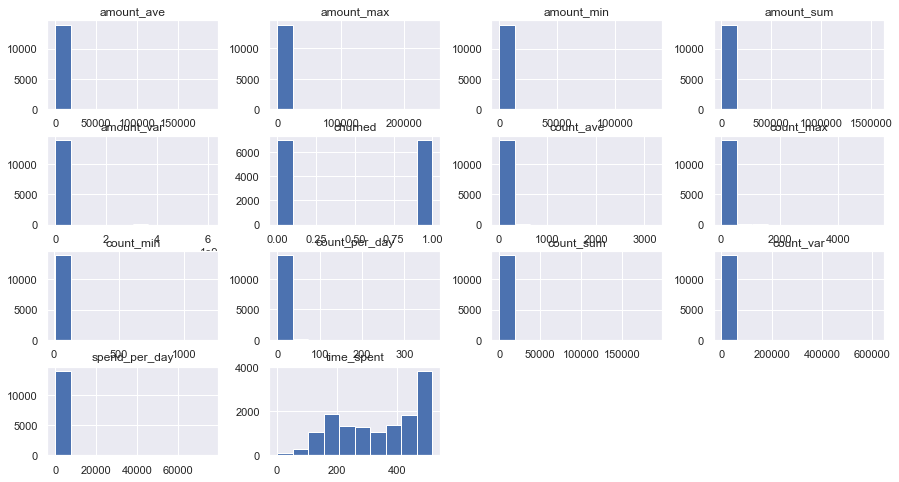

In [91]:
# Look at the distribution of each feature
df_upsampled.hist()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


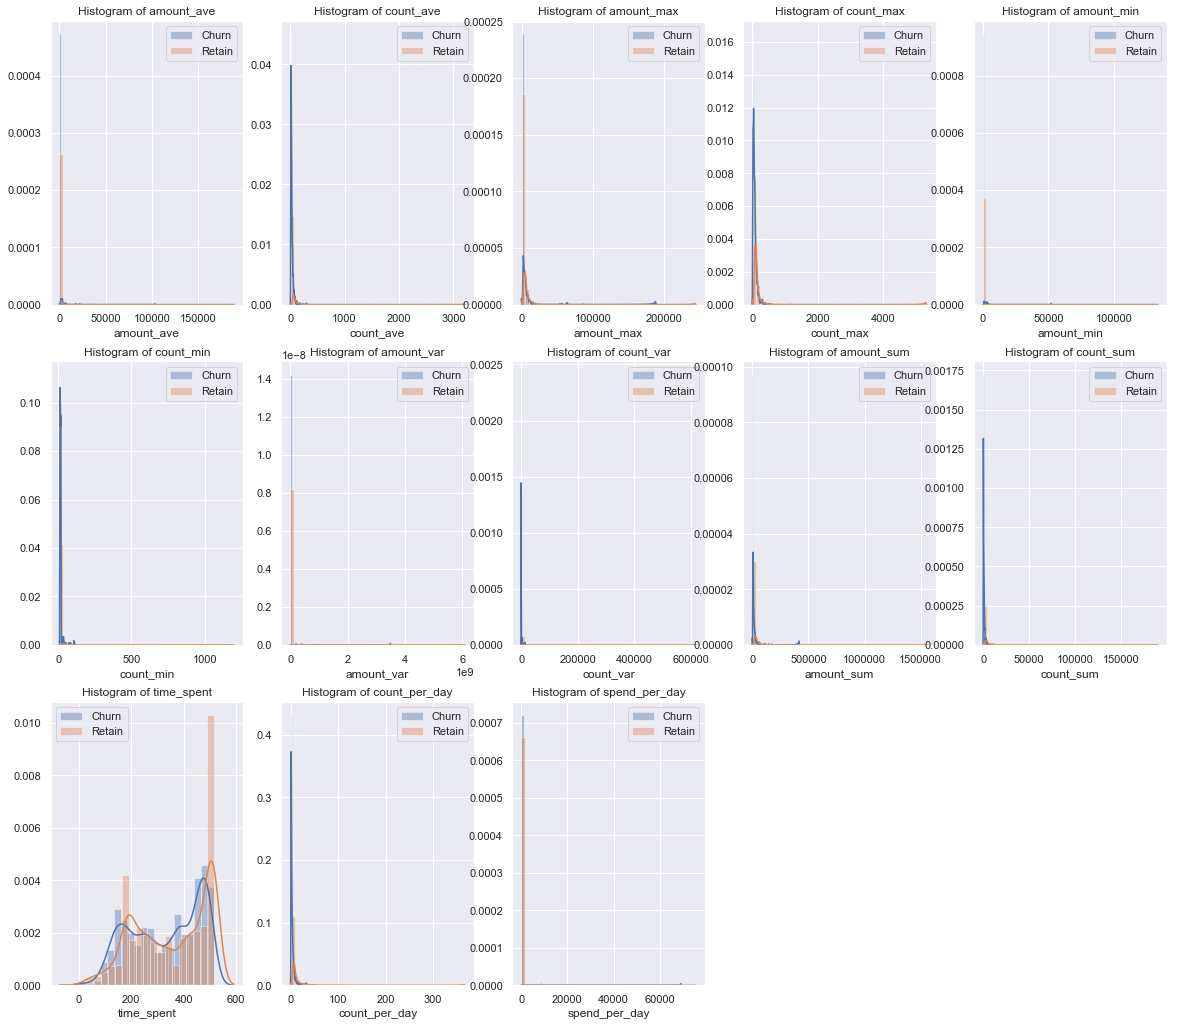

In [92]:
# Plot the distibution of each feature by label
number_of_rows    = 3
number_of_columns = 5
plt.figure(figsize=(4*number_of_columns,8*number_of_rows))

var = ['amount_ave', 'count_ave', 'amount_max', 'count_max', 'amount_min', 'count_min', 'amount_var', 'count_var', 
       'amount_sum', 'count_sum', 'time_spent', 'count_per_day', 'spend_per_day']
for i in range(0,len(var)):
    df1 = df_upsampled[df_upsampled.churned == 1]
    df2 = df_upsampled[df_upsampled.churned == 0]
    
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df1[var[i]],kde=True,label="Churn")
    sns.distplot(df2[var[i]],kde=True,label="Retain")
    plt.title("Histogram of "+str(var[i]))
    plt.legend()

plt.savefig('/distr.png')

In [93]:
# Check the data balance
df_upsampled.churned.value_counts()

1    6994
0    6994
Name: churned, dtype: int64

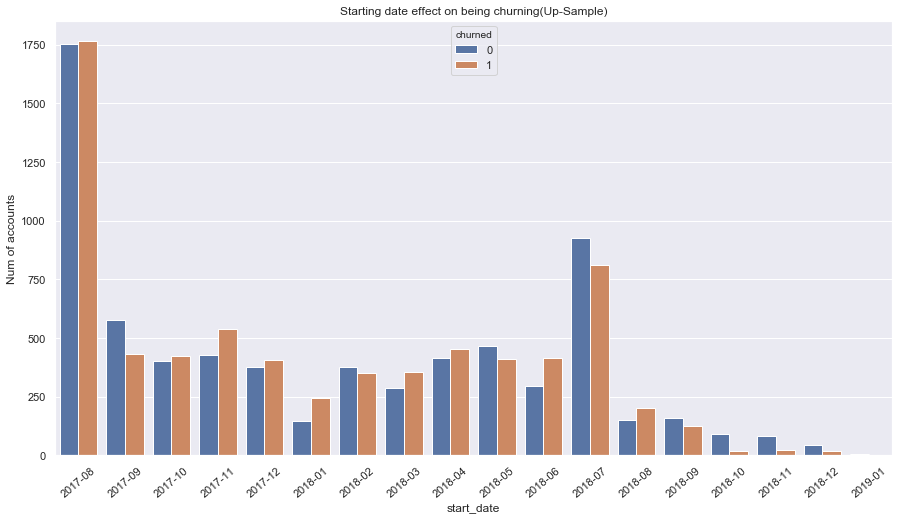

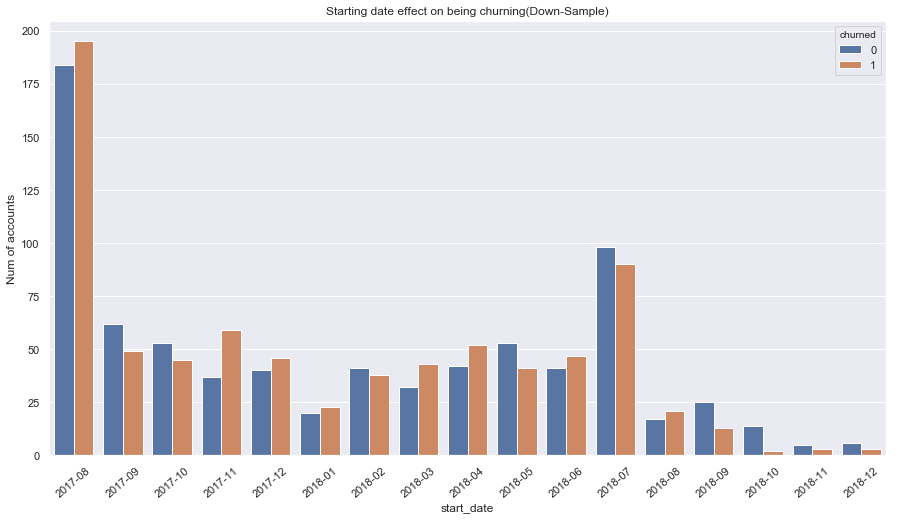

In [94]:
# Categorical Feature analysis

#Upsample
start_distri = df_upsampled[["start_date","churned", "amount_ave"]].groupby(["start_date","churned"]).count()
start_distri = start_distri.reset_index()
sns.barplot(x="start_date", y="amount_ave", hue="churned", data=start_distri)
plt.xticks(x=start_distri.start_date, label=start_distri.start_date, rotation=40)
plt.title("Starting date effect on being churning(Up-Sample)")
plt.ylabel("Num of accounts")
plt.show()

#Downsample
start_distri = df_downsampled[["start_date","churned", "amount_ave"]].groupby(["start_date","churned"]).count()
start_distri = start_distri.reset_index()
sns.barplot(x="start_date", y="amount_ave", hue="churned", data=start_distri)
plt.xticks(x=start_distri.start_date, label=start_distri.start_date, rotation=40)
plt.title("Starting date effect on being churning(Down-Sample)")
plt.ylabel("Num of accounts")
plt.show()

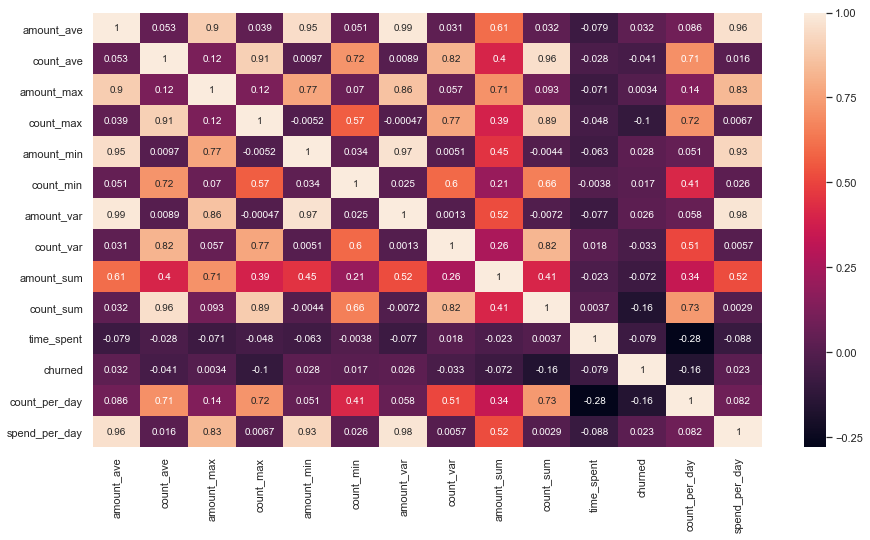

In [95]:
# Linear correlation between variables
plt.rcParams['figure.figsize'] = [15, 8]
ax = sns.heatmap(df_upsampled.corr(),annot=True)

## Feature Engineering

In [96]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

y = df_upsampled["churned"]
X = df_upsampled.reset_index().drop(["churned", "start_date", "account"], axis=1)

start_date = [[i] for i in df_upsampled.start_date.tolist()]
enc = OneHotEncoder()
enc.fit(start_date)
names      = [i[3:] for i in enc.get_feature_names().tolist()]
start_date = pd.DataFrame(enc.transform(start_date).toarray(), columns=names)
X = X.merge(start_date, left_index=True, right_index=True).drop("index", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Model Selection

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# Decision Tree
parameters = {'min_samples_split':[2,4,5], 'min_samples_leaf':[1,2,3]}
dt         = DecisionTreeClassifier(random_state=0)
clf        = GridSearchCV(dt, parameters, cv=5, scoring="f1").fit(X_train, y_train)
pred_y_0   = clf.predict(X_test)
print(classification_report(y_test, pred_y_0))
print(clf.best_params_)

# Logistic Regression
parameters = {'penalty':['l2','l1'], 'C':[1,2,3,4]}
lr         = LogisticRegression()
clf        = GridSearchCV(lr, parameters, cv=5, scoring="f1").fit(X_train, y_train)
pred_y_0   = clf.predict(X_test)
print(classification_report(y_test, pred_y_0))
print(clf.best_params_)

# Random Forest
parameters = {'max_depth':[15,17,21,24,26], 'n_estimators':[100, 150]}
rf         = RandomForestClassifier()
clf        = GridSearchCV(rf, parameters, cv=5, scoring="f1").fit(X_train, y_train)
pred_y_0   = clf.predict(X_test)
print(classification_report(y_test, pred_y_0))
print(clf.best_params_)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2344
           1       0.92      1.00      0.96      2273

   micro avg       0.96      0.96      0.96      4617
   macro avg       0.96      0.96      0.96      4617
weighted avg       0.96      0.96      0.96      4617

{'min_samples_leaf': 1, 'min_samples_split': 2}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2344
           1       0.83      0.82      0.82      2273

   micro avg       0.83      0.83      0.83      4617
   macro avg       0.83      0.83      0.83      4617
weighted avg       0.83      0.83      0.83      4617

{'C': 3, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2344
           1       0.97      1.00      0.98      2273

   micro avg       0.98      0.98      0.98      4617
   macro avg       0.98      0.98      0.98      4617
weighted avg       0.98      0.98      0.98      4617

{'max_depth': 24, 'n_estimators': 150}


## Model Evaluation

In [108]:
# Plot ROC curve and calculate AUC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
# Decision Tree
dt         = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1).fit(X_train, y_train)
pred_y_0   = dt.predict(X_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, pred_y_0)

# Logistic Regression
lr         = LogisticRegression(penalty="l1", C=3).fit(X_train, y_train)
pred_y_0   = lr.predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_y_0)

# Random Forest
rf         = RandomForestClassifier(max_depth=24, n_estimators=150).fit(X_train, y_train)
pred_y_0   = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_y_0)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


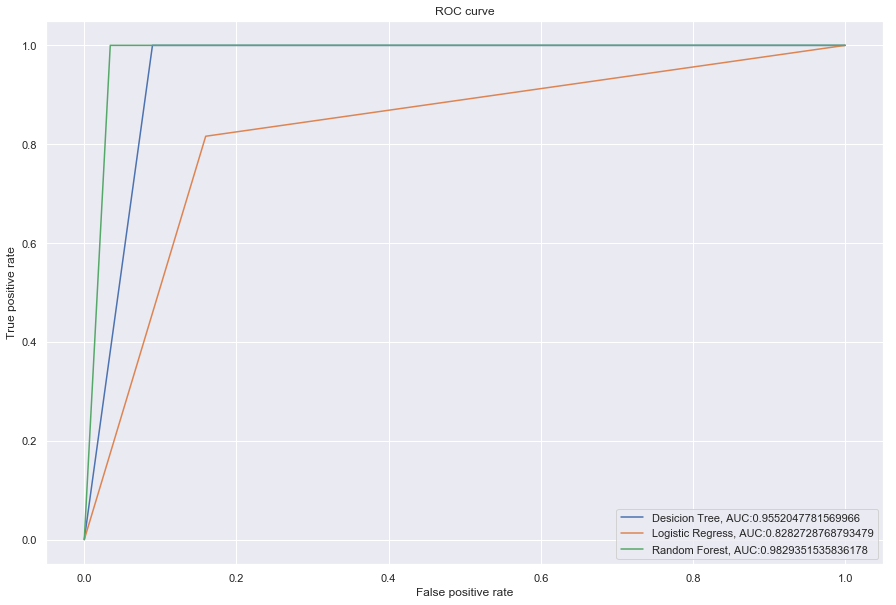

In [109]:
# Plot ROC with AUC
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(fpr_dt, tpr_dt, label='Desicion Tree, AUC:'+str(auc(fpr_dt, tpr_dt)))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regress, AUC:'+str(auc(fpr_lr, tpr_lr)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest, AUC:'+str(auc(fpr_rf, tpr_rf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Feature Importance

In [110]:
# Collect feature importance
feature_import = {}
#dt         = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1)
rf         = RandomForestClassifier(max_depth=26, n_estimators=100)
rf.fit(X_train, y_train)
importance     = rf.feature_importances_.tolist()
feature        = X_train.columns.tolist()
for i, v in enumerate(feature):
    feature_import[v] = importance[i]
feature_import

{'amount_ave': 0.07547664394856633,
 'count_ave': 0.09080679442510141,
 'amount_max': 0.04299553112359002,
 'count_max': 0.04540796039843619,
 'amount_min': 0.07206340925435344,
 'count_min': 0.03038599463404095,
 'amount_var': 0.048757751199697275,
 'count_var': 0.08619778990035819,
 'amount_sum': 0.08808924081711975,
 'count_sum': 0.15569650402553187,
 'time_spent': 0.11508689313613613,
 'count_per_day': 0.09020514209529974,
 'spend_per_day': 0.05883034504176883}

In [105]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

y = df_upsampled["churned"]
X = df_upsampled.reset_index().drop(["churned", "start_date", "account"], axis=1)
X = X.drop("index", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)